In [ ]:
# Load dataset "compilado_delitos_2022.xlsx" with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Read the data, all strings
df_copy = pd.read_excel('compilado_delitos_2022.xlsx', dtype=str)


In [ ]:
df = df_copy.copy()
#Print dimensions of the dataset
print(df.shape)# Print columns of the dataset
print(df.columns)
# Print the first 5 rows of the data
df.head()

In [ ]:
''' Save columns and drop the ones that are not needed
       ['fecha_creacion', 'hora_creacion',
       'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
       'sector_inicio', 'latitud', 'longitud']
'''

# Remove YYYY-MM-DD in field hora_creacion
df['hora_creacion'] = df['hora_creacion'].str[11:13]
# Remove rows with date 2021-12-31
df = df[df.fecha_creacion != '2021-12-31']
df = df[df.fecha_creacion != '2023-01-01']
# Remove YYYY of field fecha_creacion
df['fecha_creacion'] = df['fecha_creacion'].str[5:]
# Save only MM in field fecha_creacion
#df['fecha_creacion'] = df['fecha_creacion'].str[5:7]
# Parse int to name of month in spanish
#df['fecha_creacion'] = df['fecha_creacion'].replace({'01':'01-Enero', '02':'02-Febrero', '03':'03-Marzo', '04':'04-Abril', '05':'05-Mayo', '06':'06-Junio', '07':'07-Julio', '08':'08-Agosto', '09':'09-Septiembre', '10':'10-Octubre', '11':'11-Noviembre', '12':'12-Diciembre'})
# Map dia_semana from name to int-name
df['dia_semana'] = df['dia_semana'].replace({'Lunes':'1-Lunes', 'Martes':'2-Martes', 'Miércoles':'3-Miércoles', 'Jueves':'4-Jueves', 'Viernes':'5-Viernes', 'Sábado':'6-Sábado', 'Domingo':'7-Domingo'})

columns = ['fecha_creacion', 'hora_creacion',
        'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
        'sector_inicio', 'latitud', 'longitud']

df = df[columns]



# Print the first 5 rows of the data
df.head()

In [ ]:
# Separar los datos por delitos
df_delitos = df.groupby('incidente_c4')
df_delitos.head()

In [ ]:
# 'Estadisticas trimestrales' en ingles: 'Trimestral statistics'
def statistic_frequency(df_main:pd.DataFrame, conditionals:list[pd.Series], groupby:str, titles:list[str], dir:str, num_high:int=5, num_low:int=5):
	from matplotlib.backends.backend_pdf import PdfPages
	import os

	if not os.path.exists(dir):
		os.makedirs(dir)

	with PdfPages(dir + '/'+ dir +'.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, axes = plt.subplots(nrows=1, ncols=len(conditionals), figsize=(5*len(conditionals), 5))
			# check if axes is a list or a single axis
			if not isinstance(axes, np.ndarray):
				axes = [axes]

			df_delito_pts = [delito_df[conditional] for conditional in conditionals]
			
			
			for df_section,title,axe in zip(df_delito_pts, titles, axes):
				delito_df_pt = df_section.groupby(groupby).count()['incidente_c4']
		
				delito_df_pt.plot(ax=axe)
				axe.set_title(title)
				axe.set_xticklabels(axe.get_xticklabels(), rotation=90)

				# Add scatter points with text labels to 5th hights days
				delito_df_pt1_sorted = delito_df_pt.sort_values(ascending=False)
				for i, (x, y) in enumerate(zip(delito_df_pt1_sorted.index, delito_df_pt1_sorted.values)):
					if i < num_low or i+num_high >= len(delito_df_pt1_sorted):
						x_pos = delito_df_pt.index.get_loc(x)
						axe.scatter(x_pos, y, s=10, color='black')
						axe.text(x_pos, y, str(f"{x} [{y}]"), fontsize=8, color='red' if i<num_low else 'green', rotation=90,  horizontalalignment='right', verticalalignment='top')

			#Get Max scale of all axes using get_ylim()
			y_max = max([ax.get_ylim()[1] for ax in axes])
			#Set all axes to the same scale
			for ax in axes:
				ax.set_ylim(0, y_max)


			plt.suptitle(delito)
			plt.savefig(f"{dir}/{delito}.png")
			pdf.savefig()
			plt.show()
		plt.close()

In [36]:
def statistic_heatmap(df_main:pd.DataFrame, index, columns, title, dir:str):
    import os
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages

    if not os.path.exists(dir):
        os.makedirs(dir)


    with PdfPages(f'{dir}/{dir}.pdf') as pdf:
        df_main_by_delitos = df_main.groupby('incidente_c4')
        for delito, delito_df in df_main_by_delitos:
            # Create a pivot table with the count of incidents by day and hour
            delito_df_pt = delito_df.pivot_table(index=index, columns=columns, values='incidente_c4', aggfunc='count', fill_value=0)
            # Plot the heatmap
            fig, ax = plt.subplots()
            sns.heatmap(delito_df_pt, cmap='YlGnBu', ax=ax)
            ax.set_title(title)
            plt.suptitle(delito)
            pdf.savefig()
            plt.savefig(f"{dir}/{delito}.png")
            plt.show()

In [ ]:
statistic_frequency(
	df,
	[df['hora_creacion']<''],
	'hora_creacion',
	['Enero - Diciembre 2022'],
    'tendencia_diaria',
    2,2
)

In [ ]:
statistic_frequency(
	df,
	[df['incidente_c4']>''],
	'dia_semana',
	['Enero - Diciembre 2022'],
    'tendencia_semanal',
    2,2
)

In [ ]:
statistic_frequency(
	df,
	[
		df['fecha_creacion'] < '04-01',
		((df['fecha_creacion'] >= '04-01') & (df['fecha_creacion'] < '07-01')),
		((df['fecha_creacion'] >= '07-01') & (df['fecha_creacion'] < '10-01')),
		(df['fecha_creacion'] >= '10-01')
	], 
	'fecha_creacion', 
	['Enero - Marzo 2022', 'Abril - Junio 2022', 'Julio - Septiembre 2022', 'Octubre - Diciembre 2022'],
	'tendencia_trimestral',
	0, 3
)

In [41]:
def statistic_geomap(df_main:pd.DataFrame, groupby:str, title:str, dir:str, USE_SECTORS:bool=True):
    import os
    import geopandas as gpd
    from shapely.geometry import Point
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.pyplot as plt
    import seaborn as sns

    if not os.path.exists(dir):
        os.makedirs(dir)

    if USE_SECTORS:
        mxcity = gpd.read_file('mapa_mexico_sectores/')\
            .set_index('TERRITORIA')\
            .to_crs(epsg=4326)
    else:
        # Obtain the map of Mexico
        mx = gpd.read_file('mapa_mexico/')\
                .set_index('CLAVE')\
                .to_crs(epsg=4326)
        # obtain the map of Mexico City with the geometry of the city
        mxcity = mx.query('CVE_EDO==\"09\"')

    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}


    with PdfPages(f'{dir}/{dir}.pdf') as pdf:
        df_main_by_delitos = df_main.groupby('incidente_c4')
        for delito, delito_df in df_main_by_delitos:
            fig, ax = plt.subplots(figsize=(10, 10))

            mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
            #mxcity.plot(ax=ax, color='white', edgecolor='black')

            # Create a GeoDataFrame from the DataFrame
            gdf = gpd.GeoDataFrame(
                delito_df, 
                crs=crs,
                geometry=gpd.points_from_xy(delito_df.longitud, delito_df.latitud)
            )

            # Plot the incidents
            gdf.plot(ax=ax, markersize=2, color='#26A337', alpha=0.075)

            # Add a title
            ax.set_title(title)
            plt.suptitle(delito)
            pdf.savefig()
            plt.savefig(f"{dir}/{delito}.png")
            plt.show()

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


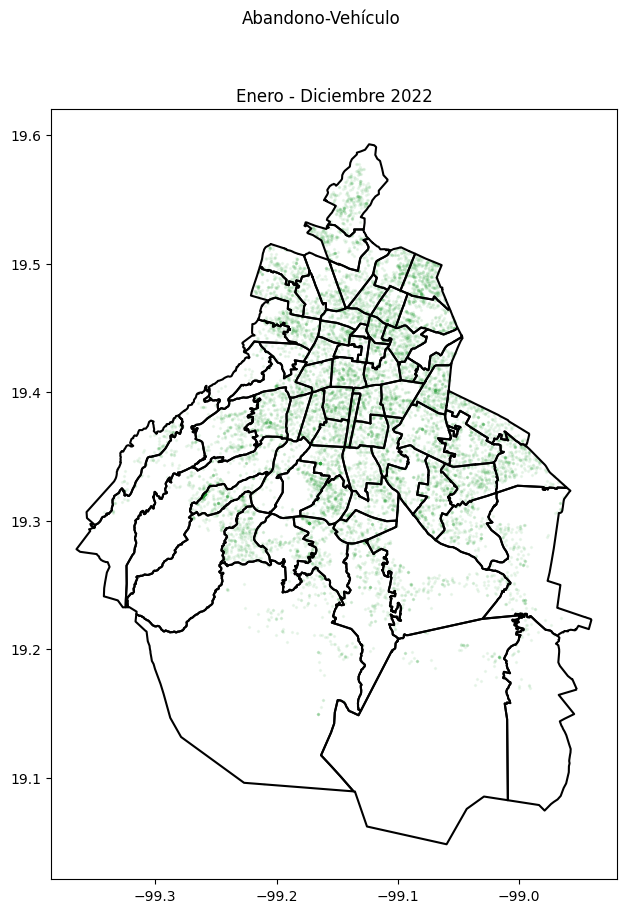

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


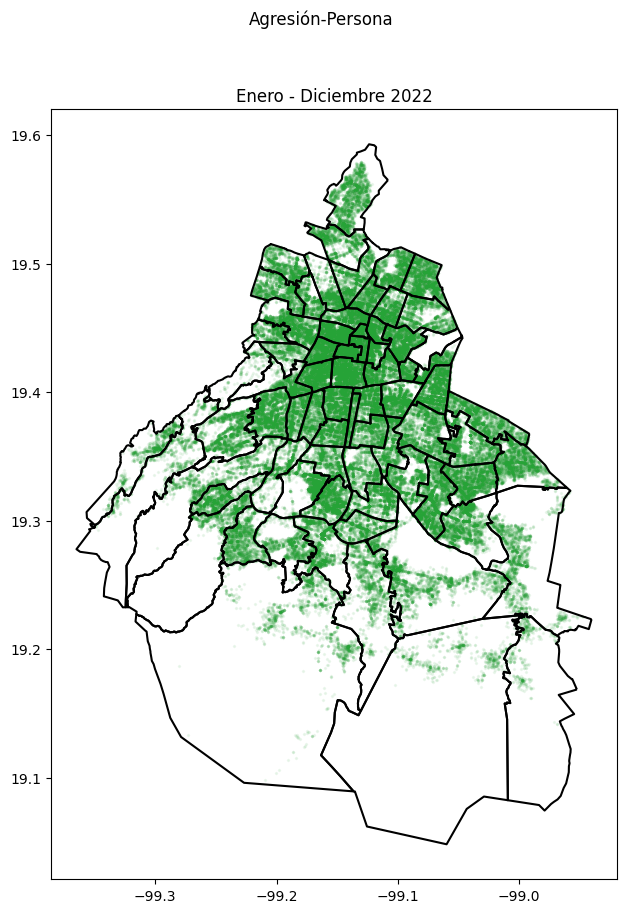

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


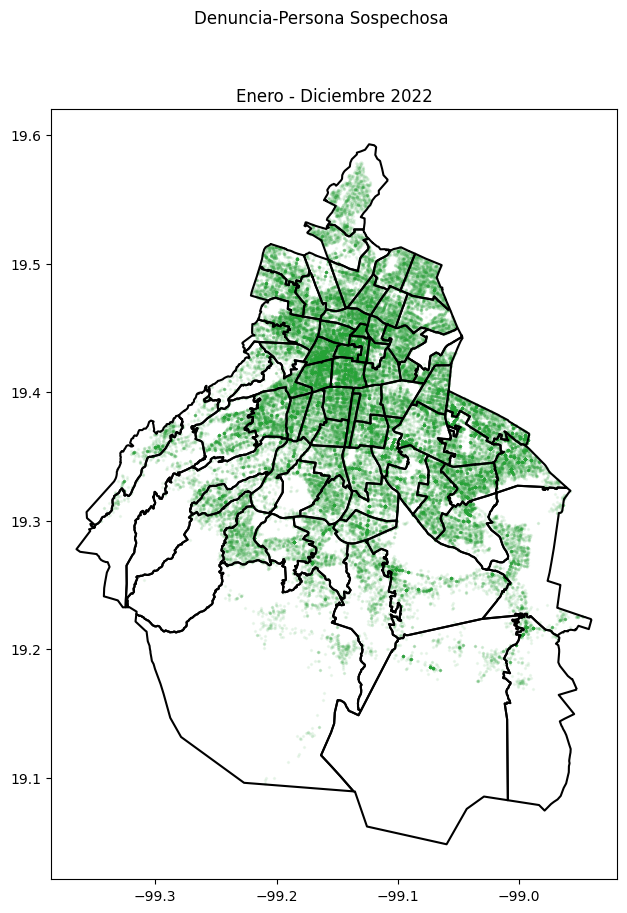

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


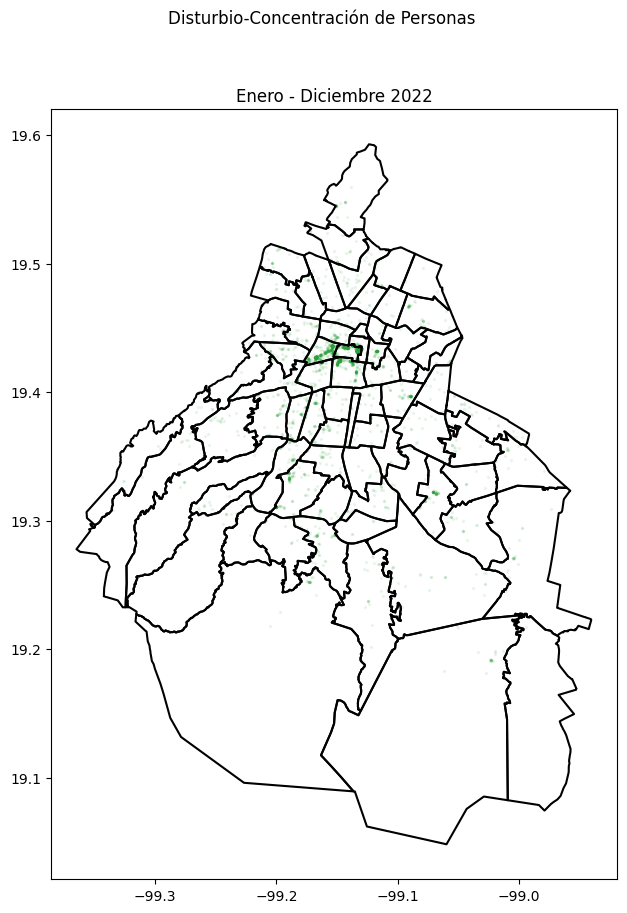

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


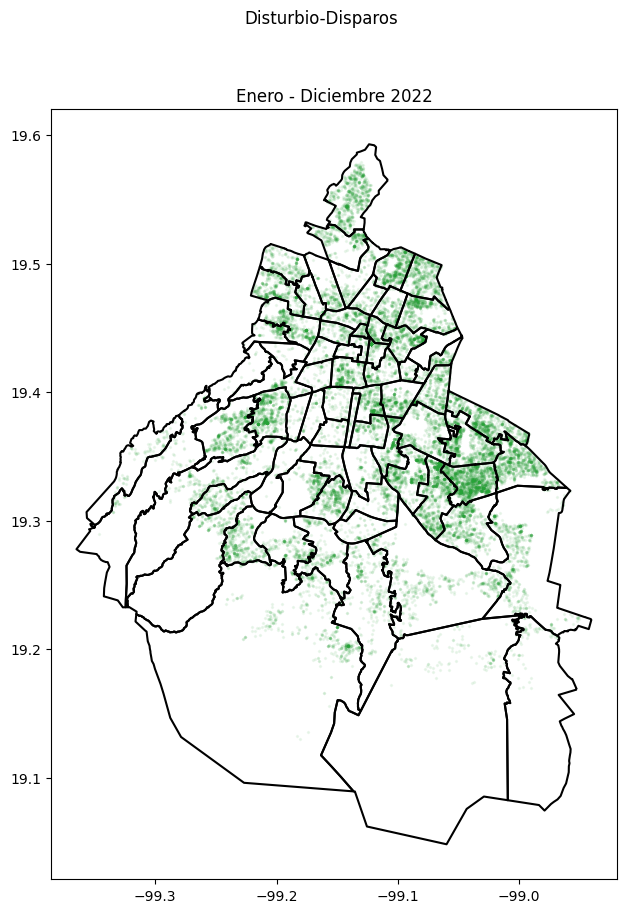

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


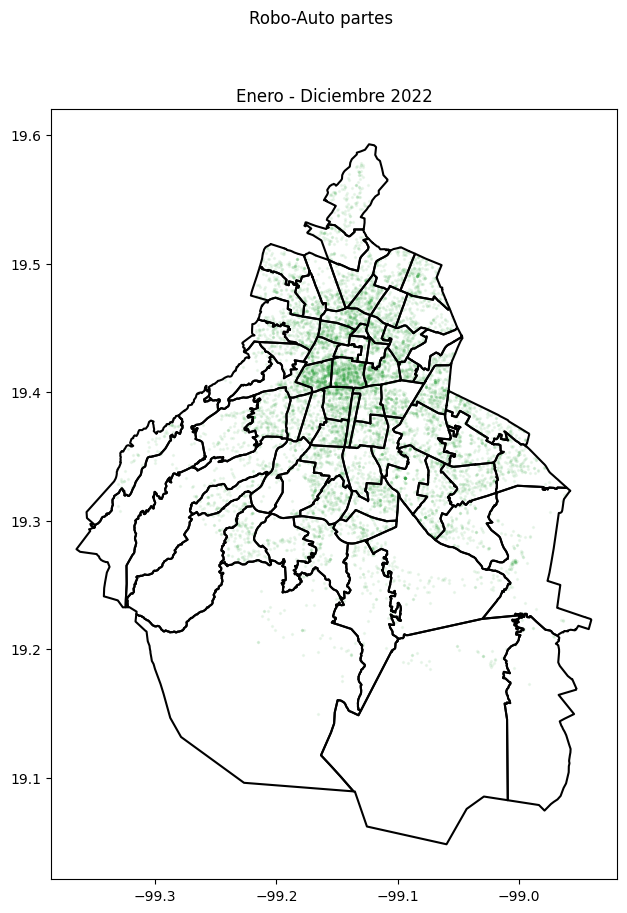

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


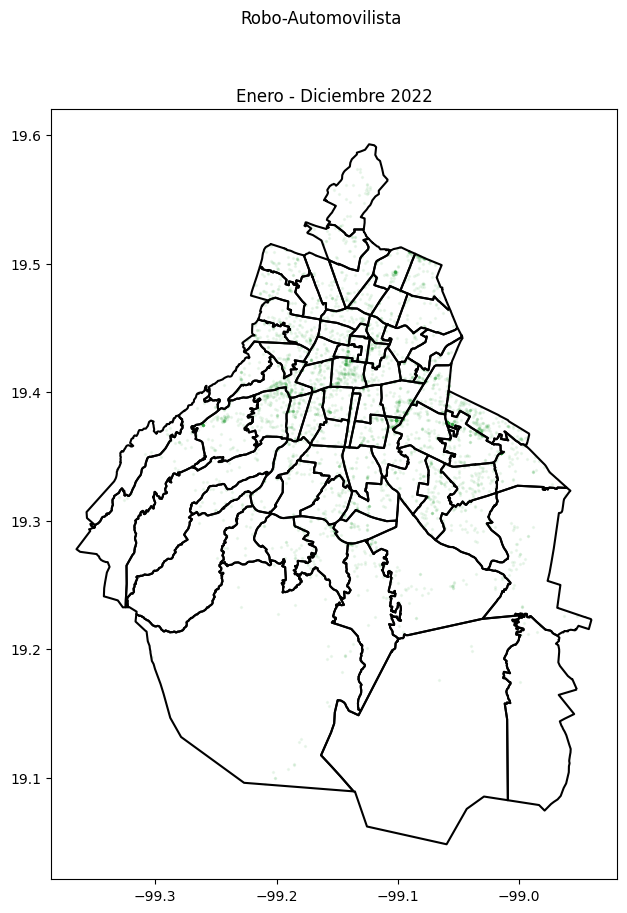

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


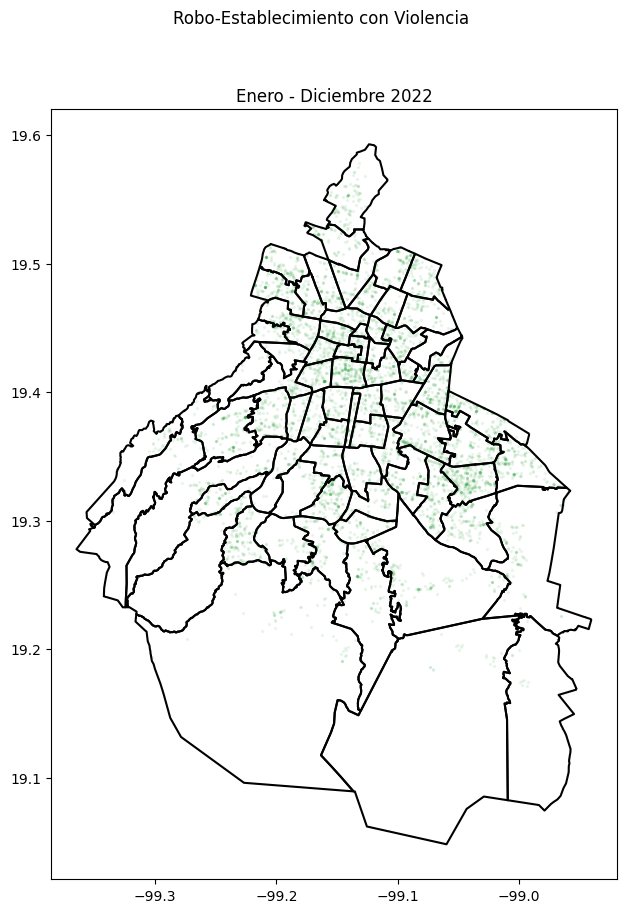

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


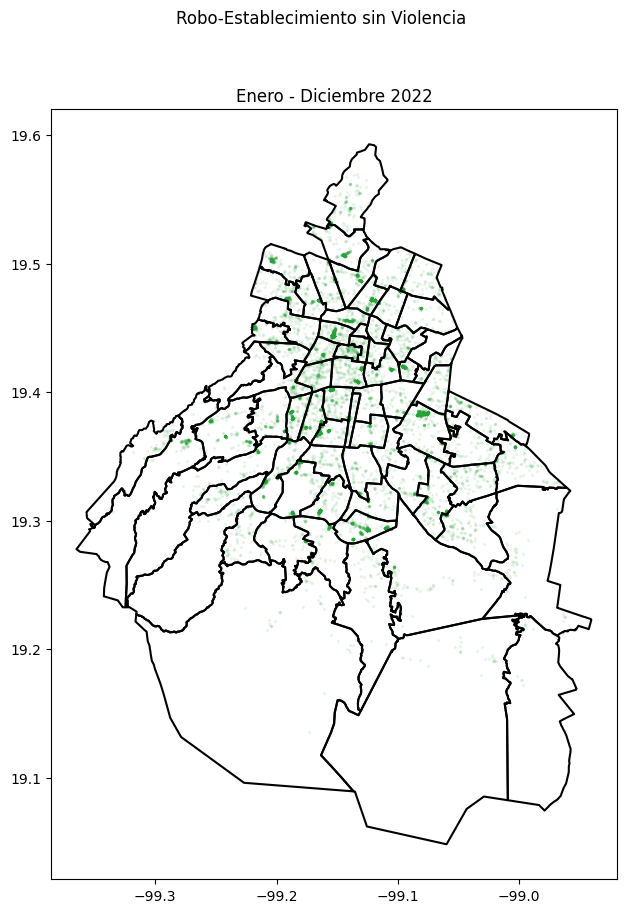

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


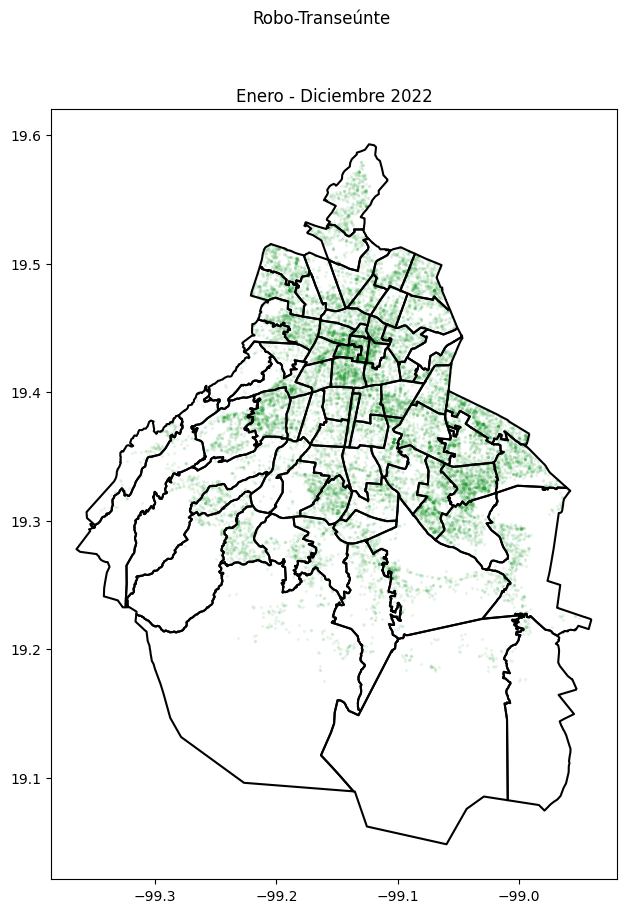

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


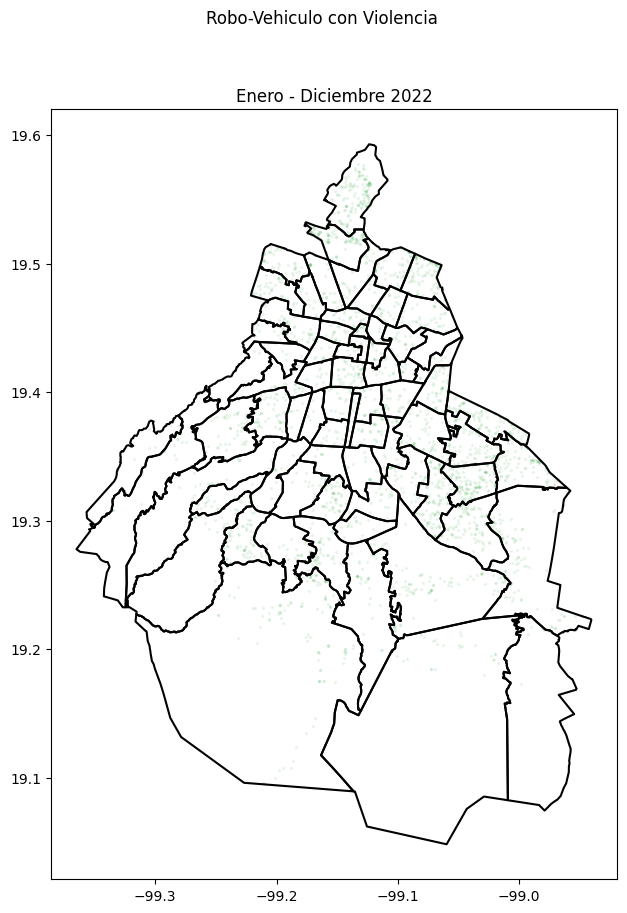

/opt/conda/envs/c5/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


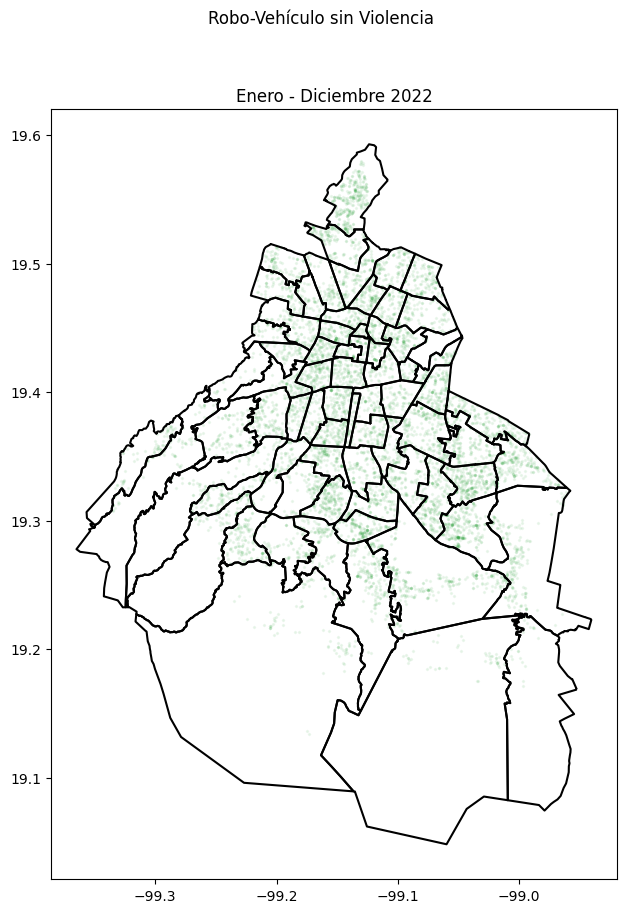

In [42]:
statistic_geomap(df, 'incidente_c4', 'Enero - Diciembre 2022', 'geomap_anual', True)

In [ ]:
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.backends.backend_pdf import PdfPages
USE_SECTORS = True

dir = 'geolocalizacion'
if not os.path.exists(dir):
    os.makedirs(dir)

if USE_SECTORS:
    mxcity = gpd.read_file('mapa_mexico_sectores/')\
		.set_index('TERRITORIA')\
		.to_crs(epsg=4326)
else:
    # Obtain the map of Mexico
    mx = gpd.read_file('mapa_mexico/')\
            .set_index('CLAVE')\
            .to_crs(epsg=4326)
    # obtain the map of Mexico City with the geometry of the city
    mxcity = mx.query('CVE_EDO==\"09\"')

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

with PdfPages(f'{dir}/{dir}.pdf') as pdf:
    for delito, delito_df in df_delitos:		
        
        #print(mxcity.head())
        fig, ax = plt.subplots()
        # cmap to empty to avoid the color of the map
        mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
        fig.set_size_inches(12, 8)

        # set title with df incidente_c4
        ax.set_title('Enero - Diciembre 2022')

		
        # Create a new column with the geometry of the points
        delito_df['geometry'] = delito_df.apply(lambda x: Point((float(x.longitud), float(x.latitud))), axis=1)
        # Create a new dataframe with the geometry of the points
        gdf = gpd.GeoDataFrame(delito_df, crs=crs, geometry='geometry')
        # Plot the points
        gdf.plot(ax=ax, color='#26A337', markersize=2, alpha=0.1)
        fig.set_size_inches(5, 5)

        plt.suptitle(delito)
        pdf.savefig()
        plt.savefig(f"{dir}/{delito}.png")
        plt.show()

In [ ]:
statistic_heatmap(
    df,
    'hora_creacion',
    'dia_semana',
    'Enero - Diciembre 2022',
    'heatmap_dia_hora',
)

In [ ]:
# Create a heatmap with params hora_creacion, dia_semana in a plot

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dir = 'heatmap_dia_hora'
if not os.path.exists(dir):
    os.makedirs(dir)

with PdfPages(f'{dir}/{dir}.pdf') as pdf:
    for delito, delito_df in df_delitos:
        # Create a pivot table
        delito_df_pt = delito_df.pivot_table(index='hora_creacion', columns='dia_semana', aggfunc='size', fill_value=0)
        # Plot the heatmap
        fig, ax = plt.subplots()
        sns.heatmap(delito_df_pt, ax=ax, cmap='YlGnBu')
        ax.set_title('Enero - Diciembre 2022')
        plt.suptitle(delito)
        pdf.savefig()
        plt.savefig(f"{dir}/{delito}.png")
        plt.show()

        
